# Assignment: Recommender Systems, Clustering and PCA

<div class="alert alert-danger" role="alert">
  Note: <br>
    1. Only modify the area marked by "YOUR CODE STARTS HERE" and "YOUR CODE ENDS HERE" markers<br>
    2. If you are working locally, the data files should be in the same directory as your Assignment4.ipynb Notebook.<br>
</div>

# Exercise: Recommender System

In this exercise, we provide you with an implementation of a collaborative-filtering recommender system. Your task is to train the recommender system on the MovieLens dataset with 100k ratings: https://grouplens.org/datasets/movielens/100k/. When you unzip the zip assignment file, the dataset will be in the same directory of your assignment.

## MovieLens Dataset Exploration and Preparation

The below code demonstrates the initial steps of exploring and preparing the MovieLens dataset. The dataset contains information about users, movies, and ratings.

- Users Data: Contains information about users such as user ID, age, sex, occupation, and zip code.
- Ratings Data: Includes user ratings for movies, along with timestamps.
- Movies Data: Provides details about movies, including movie ID, title, release date, video release date, and IMDb URL.

**Merging**: Combines information from movies, ratings, and users into a single dataframe (lens).

**Movie Index Dictionary**: Maps movie titles to their corresponding movie IDs (`movie_idx`) and vice versa (`idx_movie`). This mapping is useful for easy reference and retrieval of movie information.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Reading users file
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1')
# Reading data file
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')
# Reading items file
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')
# merging data as one dataframe
movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)

movie_idx = {}
idx_movie = {}
for i in movies.values:
    movie_idx[i[1]] = i[0]
    idx_movie[i[0]] = i[1]

## Creating User-Item Rating Matrix

Below we create a user-item rating matrix from the MovieLens dataset. The process includes mapping unique user (`user_id`) and movie IDs (`movie_id`), and then constructing a pivot table to form the `rating matrix`.

In [2]:
# unique users ids data
user_map = pd.Series(
    index=np.unique(lens['user_id']),
    data=np.arange(lens['user_id'].nunique()),
    name='user_map')

# unique movies ids data
movie_map = pd.Series(
    index=np.unique(lens['movie_id']),
    data=np.arange(lens['movie_id'].nunique()),
    name='movie_map')
# mapping unique users ids to the lens data
user_inds = lens['user_id'].map(user_map)
# mapping unique movies ids to the lens data
movie_inds = lens['movie_id'].map(movie_map)

# creating a pivot table of user_id, movie_id, and rating
rating_matrix = (
        pd.pivot_table(
            data=lens,
            values='rating',
            index=user_inds,
            columns=movie_inds,
        ).fillna(0).values
)
rating_matrix

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

## Matrix Factorization
The code defines a class named `MatrixFactorization` to implement matrix factorization for collaborative filtering. This technique is used for predicting user ratings for movies based on latent features.

Parameters:
- rating_matrix: The matrix of user ratings (row: user, col: movie).
- rating_matrix_val: Validation set for model evaluation.
- k: Number of latent features.
- lmbda: Regularization parameter.
- max_epochs: Maximum number of iterations.
- lr: Learning rate

In [3]:
# MatrixFactorization class
class MatrixFactorization():
    # constructor
    def __init__(self, rating_matrix, rating_matrix_val, k=5, lmbda=0.01, max_epochs=50, lr=0.1):
        '''
        rating_matrix: the matrix of rating (row: user, col: movie)
        k : int, default=2
            Number of latent features
        lmbda : float, default=0.01
            Regularization parameter
        max_epochs : int, default=15
            Max number of iterations to run
        lr: float, default:0.1
            Learning rate
        '''
        self.rating_matrix = rating_matrix
        self.rating_matrix_val = rating_matrix_val
        self.k = k
        self.lmbda = lmbda
        self.max_epochs = max_epochs
        self.lr = lr
        self.U = np.random.normal(scale=1./self.k, size=(rating_matrix.shape[0], self.k))
        self.V = np.random.normal(scale=1./self.k, size=(self.k, rating_matrix.shape[1]))
        self.b_u = np.zeros(rating_matrix.shape[0])
        self.b_i = np.zeros(rating_matrix.shape[1])
        self.b = np.mean(rating_matrix[np.where(rating_matrix != 0)])
        self.mean_squared_errors = []
        self.mean_squared_errors_val = []
    # fitting the model
    # The method fits the model by iterating through the specified number of epochs
    # and updating model parameters using stochastic gradient descent.
    def fit(self):
        for it in range(self.max_epochs):
            for i in range(len(self.rating_matrix)):
                for j in range(len(self.rating_matrix[i])):
                    if self.rating_matrix[i][j] > 0:
                        eij = self.rating_matrix[i][j] - (self.predict_rating_user_movie(i, j))
                        self.b_u[i] += self.lr * (eij - self.lmbda * self.b_u[i])
                        self.b_i[j] += self.lr * (eij - self.lmbda * self.b_i[j])
                        self.U[i,:] += self.lr * (eij * self.V[:,j] - self.lmbda * self.U[i,:])
                        self.V[:,j] += self.lr * (eij * self.U[i,:] - self.lmbda * self.V[:,j])

            self.mean_squared_errors.append(self.mse_training(self.rating_matrix, self.predict()))
            self.mean_squared_errors_val.append(self.mse_validation(self.rating_matrix, self.rating_matrix_val, self.predict()))

    # reporting model's mse using the training set
    # Calculates Mean Squared Error (MSE) for training sets.
    def mse_training(self, true_rating, pred_rating):
        '''
        pred_matrix: the predict matrix of rating (row: user, col: movie)
        return: mean squared error
        '''
        error = 0
        for rt, rp in zip(true_rating, pred_rating):
            for vt, vp in zip(rt, rp):
                if vt > 0:
                    error += pow(vt - vp, 2)
        return np.sqrt(error)

    # reporting model's mse using testing set
    # Calculates Mean Squared Error (MSE) for training set.
    def mse_validation(self, true_rating, test_rating, pred_rating):
        '''
        pred_matrix: the predict matrix of rating (row: user, col: movie)
        return: mean squared error
        '''
        error = 0
        for rt, rtt, rp in zip(true_rating, test_rating, pred_rating):
            for vt, vtt, vp in zip(rt, rtt, rp):
                if vt == -1:
                    error += pow(vtt - vp, 2)
        return np.sqrt(error)

    # predicting the user's movie rating
    def predict_rating_user_movie(self, i, j):
        '''
        i: user row
        j: movie col
        '''
        return self.b + self.b_u[i] + self.b_i[j] + np.dot(self.U[i,:],self.V[:,j])

    # rating prediction
    # Predicts the rating for a given user i and movie j.
    def predict(self):
        '''
        return: rating prediction
        '''
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:, ] + np.dot(self.U, self.V)

    # plotting model's loss
    def plot_loss(self):
        iters = [i for i in range(self.max_epochs)]
        plt.xlabel("Iterations")
        plt.ylabel("Mean Squared Error")
        plt.plot(iters, self.mean_squared_errors)
        plt.plot(iters, self.mean_squared_errors_val)

    # mean square error result
    def mse_result(self):
        return self.mean_squared_errors[-1]



## Data Splitting for Training and Validation Sets

The code defines a function `create_training_validation_set` to split the given `rating_matrix` into training and validation sets for model evaluation. The splitting is done by randomly selecting a subset of ratings (`20%`) from the original matrix and masking them in the training set.



In [4]:
# splitting data into train and validation sets
def create_training_validation_set(rating_matrix):
    r_test = rating_matrix.copy()
    r_train = rating_matrix.copy()

    for r in range(0,r_train.shape[0]):
        for c in range(0, r_train.shape[1]):
            if np.random.rand()<0.2 and r_train[r,c] != 0:
                r_train[r,c] = -1

    return np.asarray(r_train), r_test

rating_matrix_training, rating_matrix_test = create_training_validation_set(rating_matrix)

## Finding Top Similar Movies

`find_top_close_movies` is used to identify the top similar movies to a given movie based on movie filtering.


In [5]:
# finding top movies
def find_top_close_movies(movie_idx, idx_movie, pred_rating, movie_name):
    movie_to_check = pred_rating[:, movie_idx[movie_name]] # 'Star Wars (1977)'
    df1 = pd.DataFrame(pred_rating)
    df2 = pd.DataFrame(movie_to_check)
    df = df1.corrwith(df2[0], axis=0)
    results = df.sort_values(ascending=False).head(4)[1:]
    for i, j in zip(list(results.index), results.values):
        print(idx_movie[i], j)

## Recommending Movies to a User
`recommend_movies_to_user` is used to recommend movies to a given user based user filtering.

In [6]:
# recommending movies
def recommend_movies_to_user(idx_movie, pred_rating, user_id):
    user_to_check = pred_rating[user_id, :]
    df1 = pd.DataFrame(pred_rating)
    df2 = pd.DataFrame(user_to_check)
    df = df1.corrwith(df2[0], axis=1)
    results = df.sort_values(ascending=False).head(6)[1:]

    movie_index = []
    for i in results.index:
        movie_index.append(pred_rating[i,:])

    movie_index = np.asarray(movie_index)

    movie_index = np.mean(movie_index, axis=0)

    results = pd.DataFrame(movie_index).sort_values(by=0, ascending=False).head(5)

    for i, j in zip(list(results.index), results.values):

        if user_to_check[i]:
            try:
                print(idx_movie[i])
            except Exception as e:
                pass

## Tune the hyperparameters

Below you are given a GridSerch method `grid_search` and you need to use it to tune the model

hyperparameters:
- k (number of latent features and weights)
- lmbda (regularization)
- max_epochs
- lr (learning rate).

You should then report  the training and the validation mean squared errors and plot the loss of your best model. Code snippets for doing each task are given below.  

In [7]:
# grid search function
def grid_search(parameters):
    min_mse = 1000
    best_parameters=[]
    # loop over all parameters
    for k in range( len( parameters ) ) :
        # model with the kth parameter
        model = MatrixFactorization(rating_matrix_training, rating_matrix_test,  parameters[k][0], parameters[k][1], max_epochs=parameters[k][2], lr=parameters[k][3])
        # fit model
        model.fit()
        # predict labels
        pred = model.predict()
        # measure mse
        curr_mse=model.mse_validation(rating_matrix_training, rating_matrix_test, pred)
        # find the best parameters with the minimum mse
        if min_mse > curr_mse :
            min_mse = curr_mse
            best_parameters=[parameters[k][0],parameters[k][1],parameters[k][2],parameters[k][3]]

    print( "Minimum mse achieved by our model through grid searching : ", min_mse )
    return best_parameters


You need to pass your parameters `k`, `lmbda`,`max_epochs`,`lr` and perform a grid search for hyperparameter tuning by iterating through various combinations of the parameters.

Here are typical ranges of acceptable values for each parameter in the context of hyperparameter tuning:

- `k` (Number of Latent Features):

    - Common range: 5 to 100
    - The number of latent features represents the dimensionality of the latent space used to represent users and items.
    
- `lmbda` (Regularization Parameter):

    - Common range: 0.01 to 0.1
    - Lambda is the regularization parameter that controls the trade-off between fitting the training data well and avoiding overfitting. A small value allows the model to fit the data well, while a large value prevents overfitting.
    
- `max_epochs` (Maximum Number of Epochs):

    - Common range: 10 to 100
    - The maximum number of epochs defines the number of iterations the model goes through during training. It should be set based on the convergence behavior of the model on the training data.
    
- `lr` (Learning Rate):

    - Common range: 0.001 to 0.1
    - The learning rate determines the step size at each iteration during optimization. A smaller learning rate provides more stable convergence but may result in slower training, while a larger learning rate may lead to faster convergence but risks overshooting the minimum.


In [9]:
import itertools
###### YOUR CODE STARTS HERE #####
# input your parameters
k= [10,30]
lmbda= [0.01, 0.1]
max_epochs=[15, 25]
lr=[0.001, 0.01]
###### YOUR CODE ENDS HERE #####
# merge all parameters in one list
parameters=[k,lmbda,max_epochs,lr]
parameters= list(itertools.product(*parameters))

# gridsearch
best_parameters=grid_search(parameters)

Minimum mse achieved by our model through grid searching :  130.63875401163747


**Expected Output for the grid search parameters**
<table>
  <tr>
    <td><strong>Grid Search Parameters</strong></td>
    <td>[1, 0.1, 20, 0.1]</td>
  </tr>
  <tr>
    <td><strong>Minimum MSE Achieved</strong></td>
    <td>16.410768734252652</td>
  </tr>
</table>


`best_parameters` hold the hyperparameter combination that resulted in the best model performance.

In [10]:
# report best parameters
best_parameters

[10, 0.1, 25, 0.01]

## Matrix Factorization Model with Best Parameters

Below use `MatrixFactorization` model with the best hyperparameters obtained from hyperparameter tuning.
Instantiates an instance of the `MatrixFactorization` model with the best hyperparameters obtained from the grid search (`best_k`, `best_lmbda`, `best_max_epochs`, `best_lr`).

`rating_matrix_training` and `rating_matrix_test` are matrices representing the training and validation sets, respectively.


In [25]:
# pass the best parameters to MatrixFactorization model
best_model = MatrixFactorization(rating_matrix_training, rating_matrix_test,  k=10, lmbda=0.1, max_epochs=25, lr=0.01)
# fit model
best_model.fit()
# predict labels
pred = best_model.predict()
# report best model mse score
best_model.mse_validation(rating_matrix_training, rating_matrix_test, pred)

130.87149504513525

Visualize the loss (Mean Squared Error) of the model during training epochs.

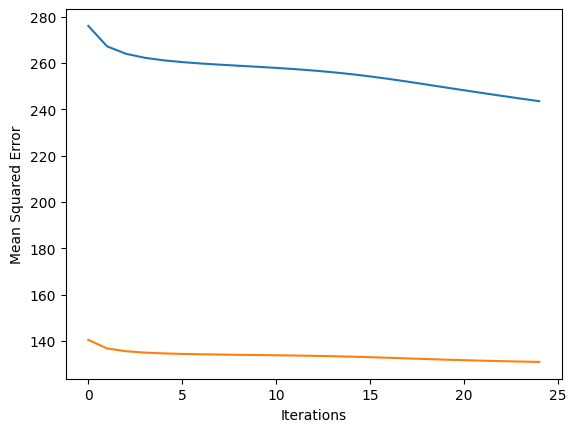

In [26]:
# plot the model loss
best_model.plot_loss()

In [27]:
# report the best model mse_results
best_model.mse_result()

243.53610253927658

### Choose a Movie

In [28]:
find_top_close_movies(movie_idx, idx_movie, pred, 'Star Wars (1977)')

Emma (1996) 0.9949089632442132
City Slickers II: The Legend of Curly's Gold (1994) 0.9941650746808908
Man of the House (1995) 0.9941405611894092


### Choose randomly a user id

In [29]:
recommend_movies_to_user(idx_movie, pred, 32)

Santa Clause, The (1994)
Spy Hard (1996)
In the Name of the Father (1993)
Monty Python and the Holy Grail (1974)
Seven (Se7en) (1995)


# Exercise: Clustering

In this assignment you will run k-means clustering and PCA on a dataset of reviews of points of interests (POIs) on TripAdvisor. The dataset tripadvisor_review.csv consists of traveler's reviews on POIs in East Asia from 10 different categories (beaches, monuments, churches, venues, etc.). Each traveler rating is mapped into a 5-point scale as follows: Excellent(4), Very Good(3), Average(2), Poor(1), and Terrible(0).

Run k-means clustering on the TripAdvisor dataset provided using the Euclidean distance as a distance metric. Vary the number of clusters K from 2 to 10. Plot the clustering cost (i.e., inertia) against the number of clusters K. Report the value of K you could deduce from  your plot (if any). Make sure you do multiple runs of the algorithm with different initializations to ensure that you don’t get stuck in a local optimum.

## Loading and Exploring TripAdvisor Review Data

In [13]:
from sklearn.cluster import KMeans
import matplotlib
# loading data
ta_data = pd.read_csv('tripadvisor_review.csv')
# features
X = ta_data.drop('User ID', axis=1)
X.head()

,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


## Determining Optimal Number of Clusters (k) using the Elbow Method

Below you will employ the Elbow Method to determine the optimal number of clusters (k) for KMeans clustering.


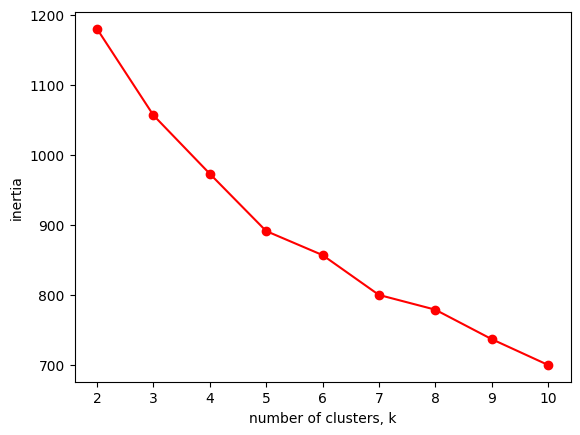

In [16]:
ks = range(2, 11)
inertias = []
for k in ks:
    ###### YOUR CODE STARTS HERE #####
    # create a KMeans instance with k clusters: model
    model =KMeans(n_clusters=k, random_state=42)
    # fit model to X
    model.fit(X)
    # append the inertia to the list of inertias
    inertias.append(model.inertia_)

    ###### YOUR CODE ENDS HERE #####

plt.plot(ks, inertias, '-o', color='red')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

## Exercise 4: PCA

Run Principal Component Analysis (PCA) on the TripAdvisor dataset and project the data into the first two principal components. Plot the dataset by projecting it on these two components and color the travlers based on their best cluster labels from exercise 1.

## Dimensionality Reduction using Principal Component Analysis (PCA)

The code demonstrates the application of [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for reducing the dimensionality of the feature data (`X`) to two principal components.

Below, we create a PCA instance (`pca`) with the number of components set to `n_components=2`, thus reducing the dimensionality to two principal components.

In [17]:
from sklearn.decomposition import PCA
import matplotlib
import seaborn as sns

# create a PCA instance: pca
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
# save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
PCA_components.rename(columns = {0:'Component1', 1:'Component2'}, inplace = True)

## Determining Optimal Number of Clusters (k) using the Elbow Method

Below you will employ the Elbow Method to determine the optimal number of clusters (k) for KMeans clustering.

**Make sure to use your reduced features.**


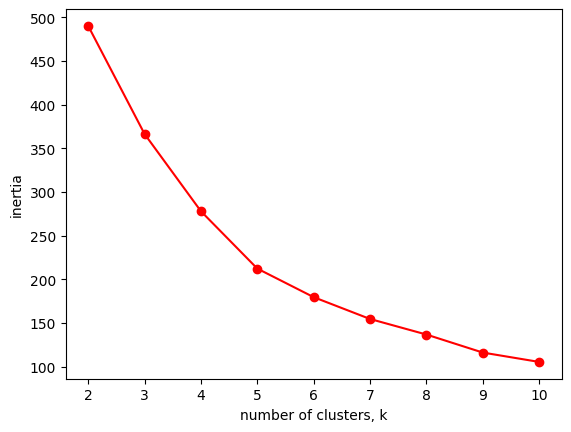

In [31]:
ks = range(2, 11)
inertias = []
for k in ks:
    ###### YOUR CODE STARTS HERE #####
    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=42)



    # fit model to samples
    model.fit(PCA_components)

    # append the inertia to the list of inertias
    inertias.append(model.inertia_)

    ###### YOUR CODE ENDS HERE #####

plt.plot(ks, inertias, '-o', color='red')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

## KMeans Clustering on PCA Components

KMeans clustering on the Principal Component Analysis (PCA) components obtained earlier and visualizes the clusters using a scatter plot.


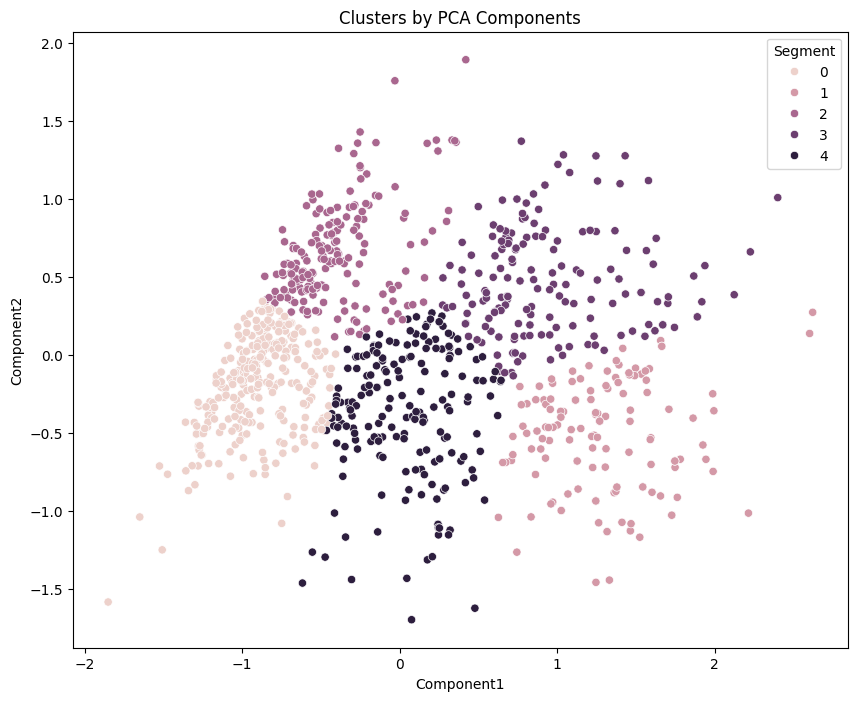

In [33]:
# pass the best number of clusters (n_clusters) as you see fit from the previous Elbow Method plot

###### YOUR CODE STARTS HERE #####
kmeans_pca=KMeans(n_clusters=5) # Replace 'best_number_of_clusters' with the optimal value
###### YOUR CODE ENDS HERE #####

# Fit the KMeans model on the PCA components
kmeans_pca.fit(PCA_components)

# concatenate data with the PCA components
df_pca_kmeans=pd.concat([X,PCA_components], axis=1)

# assign cluster labels to the DataFrame
df_pca_kmeans['Segment']=kmeans_pca.labels_

# extract PCA component values for plotting
x_axis=df_pca_kmeans['Component1']
y_axis=df_pca_kmeans['Component2']

# cluster plotting
plt.figure(figsize=(10,8))
sns.scatterplot(x=x_axis,y=y_axis, hue=df_pca_kmeans['Segment'])
plt.title('Clusters by PCA Components')
plt.show()